By Negar Vahid

In [2]:
import classiq
classiq.authenticate()

Your user code: DPCZ-CFPX
If a browser doesn't automatically open, please visit this URL from any trusted device: https://auth.classiq.io/activate?user_code=DPCZ-CFPX


#Quantum Walks

A quantum walk is a quantum analog of a classical random walk, which describes a particle's movement along the vertices of a graph. What's different is usage of quantum superposition and interference. Unlike random walks, where the particle's position *evolves* according to probabilistic rules, quantum walks leverage the principles of quantum mechanics, allowing the particle to **exist in multiple states simultaneously** and **interfere with itself**, leading to different, often faster, propagation and mixing times.

# Question 1

## Create the quantum walk operator for a circle with 4 nodes.


In the lecture, you went through a quantum operator of a square with four nodes.

We can conclude that the quantum operator for a circle with four nodes is exactly the same, Here's their Node Configuration and Connections:

**Circle with 4 Nodes:**

Nodes: 0, 1, 2, 3

Connections: 0-1, 1-2, 2-3, 3-0

**Square with 4 Nodes (with periodic boundary conditions):**

Nodes: 0, 1, 2, 3

Connections: 0-1, 1-2, 2-3, 3-0 (same as the circle)

Here is what the algorithm is doing:

- `prepare_minus()` prepares the Minus State
- The `diffuzer_oracle()` function acts as a diffuser oracle. It flips the auxiliary qubit if
𝑥
x is not equal to 0.
- The `zero_diffuzer()` function, which does the following:
 - Applies a diffuser oracle to the state:

  - Allocates an auxiliary qubit.
 - Prepares the
∣
−
⟩
∣−⟩ state on the auxiliary qubit.
 - Applies the diffuser oracle.

- The ` W_iteration()` function performs a walk iteration on the graph
  - Sets up a probability vector for the adjacent vertices.
  -    Controls the operation based on the current state of vertices.
  - Prepares the state with given probabilities on the adjacent vertices.
  - Applies the zero diffuser.

Then, we have the  Edge Oracle and Swap Operations which:
- Check if the sum of the vertices and adjacent vertices is odd.

- Swap the bits of the two given quantum arrays.




In [3]:
from classiq import *

size = 2
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0,0,0,0]
    prob[(i+1)% 4]=0.5
    prob[(i-1)% 4]=0.5
    print(f'State={i}, prob vec ={prob}')

    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices+adjacent_vertices)%2) ==1)


@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))


@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 0.5, 0, 0.5]
State=1, prob vec =[0.5, 0, 0.5, 0]
State=2, prob vec =[0, 0.5, 0, 0.5]
State=3, prob vec =[0.5, 0, 0.5, 0]
Opening: https://platform.classiq.io/circuit/e3f8461d-85ad-44de-9128-0f36339a0dfb?version=0.43.3


The walker spreads out in a superposition to adjacent nodes.

For example, for state=1:

The walker is in a superposition of nodes 0 and 2, each with a probability of 0.5. This means that after applying the coin and shift operators, the walker has an equal chance of moving to nodes 0 and 2 from node 1.


I noticed the interesting symmetric nature of the probabilities here.
The results for states 0 and 2, and states 1 and 3, are identical but shifted, reflecting the circular structure of the walk.

In [10]:
write_qmod(qmod, "question_1")

**Transpiled Circuit**: Backend name: no backend selected

Depth: 31

Width: 9

Gate count:

U : 21

CX : 21


Here is what the ciruict looks like:

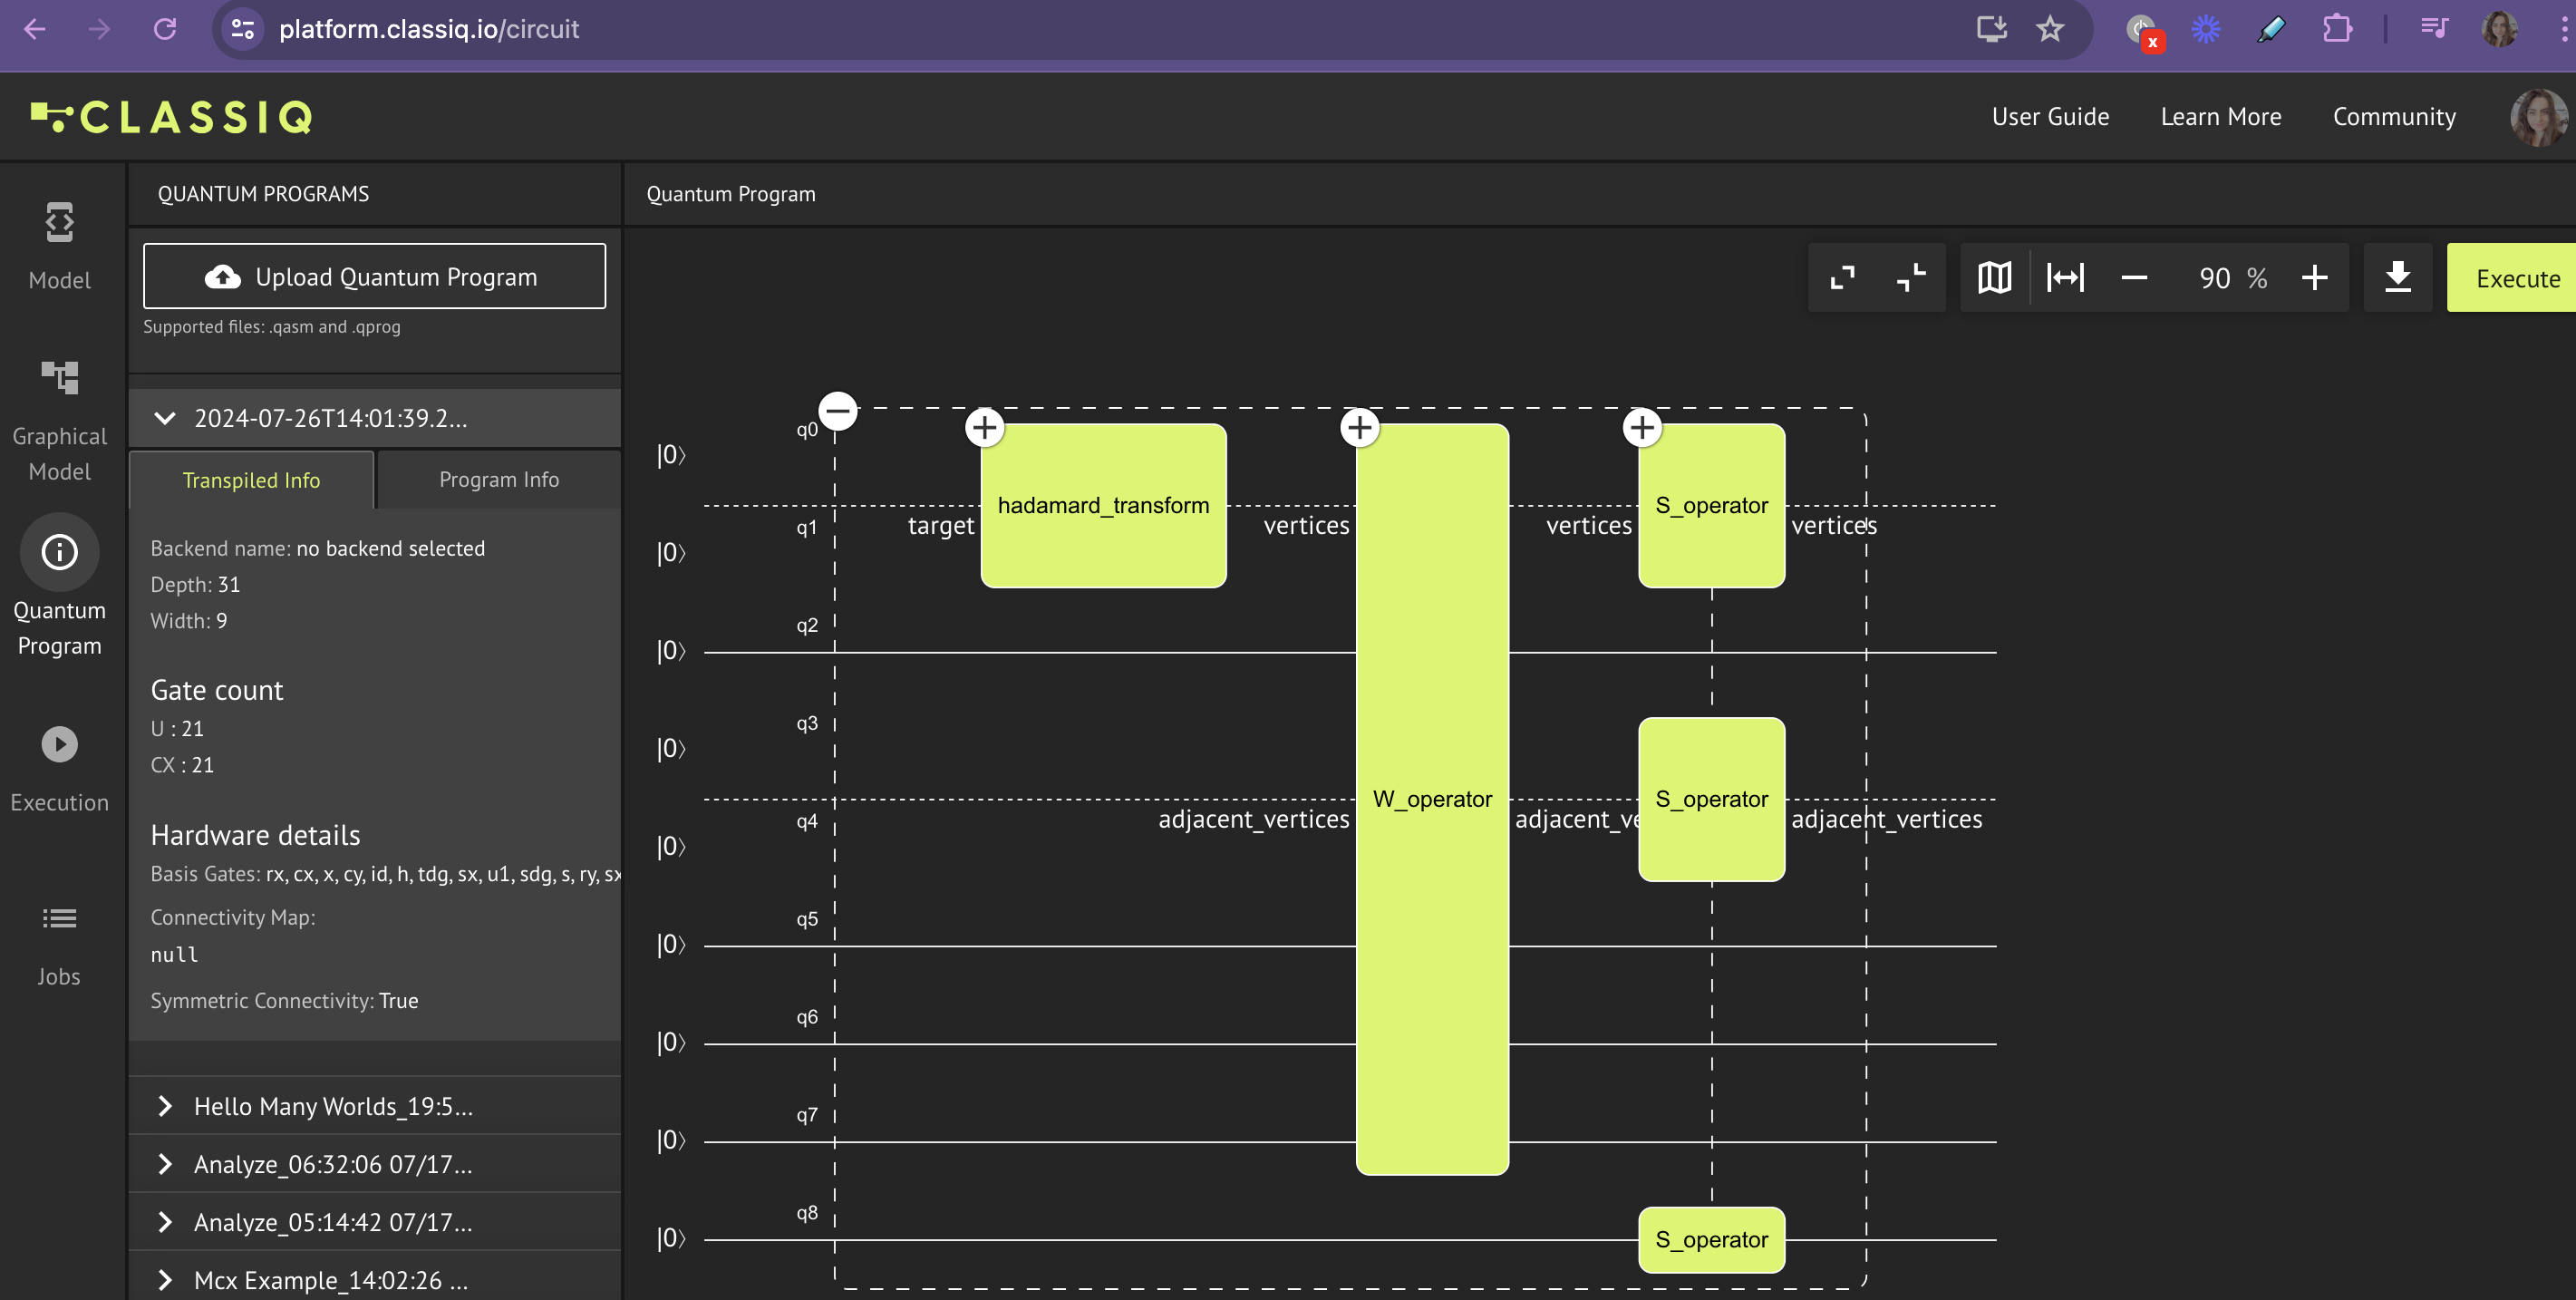

# Question 2
## Design the quantum walk operator for a line with 16 nodes.

In [5]:
size = 4 # 4-qubit system, sufficient for 16 nodes (2^4 = 16)

@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 ]
    if i==0:
      prob[1]=1
    elif i==15:
        prob[14]=1
    else:
      prob[i+1]=0.5
      prob[i-1]=0.5
    print(f'State={i}, prob vec ={prob}')

    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices+adjacent_vertices)%2) ==1)


@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))


@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 

Based on our probability vectors, For each state
𝑖:
The walker is in a superposition of nodes
𝑖
−
1
and
𝑖
+
1
with equal probability (0.5) if
𝑖
is between 1 and 14.
At the boundaries (0 and 15), the walker stays at the boundary node and the adjacent node. (which is what we expected)

In [11]:
write_qmod(qmod, "question_2")

**Transpiled Circuit**: Backend name: no backend selected

Depth: 2495

Width: 25

Gate count:

U : 2047
CX : 1929

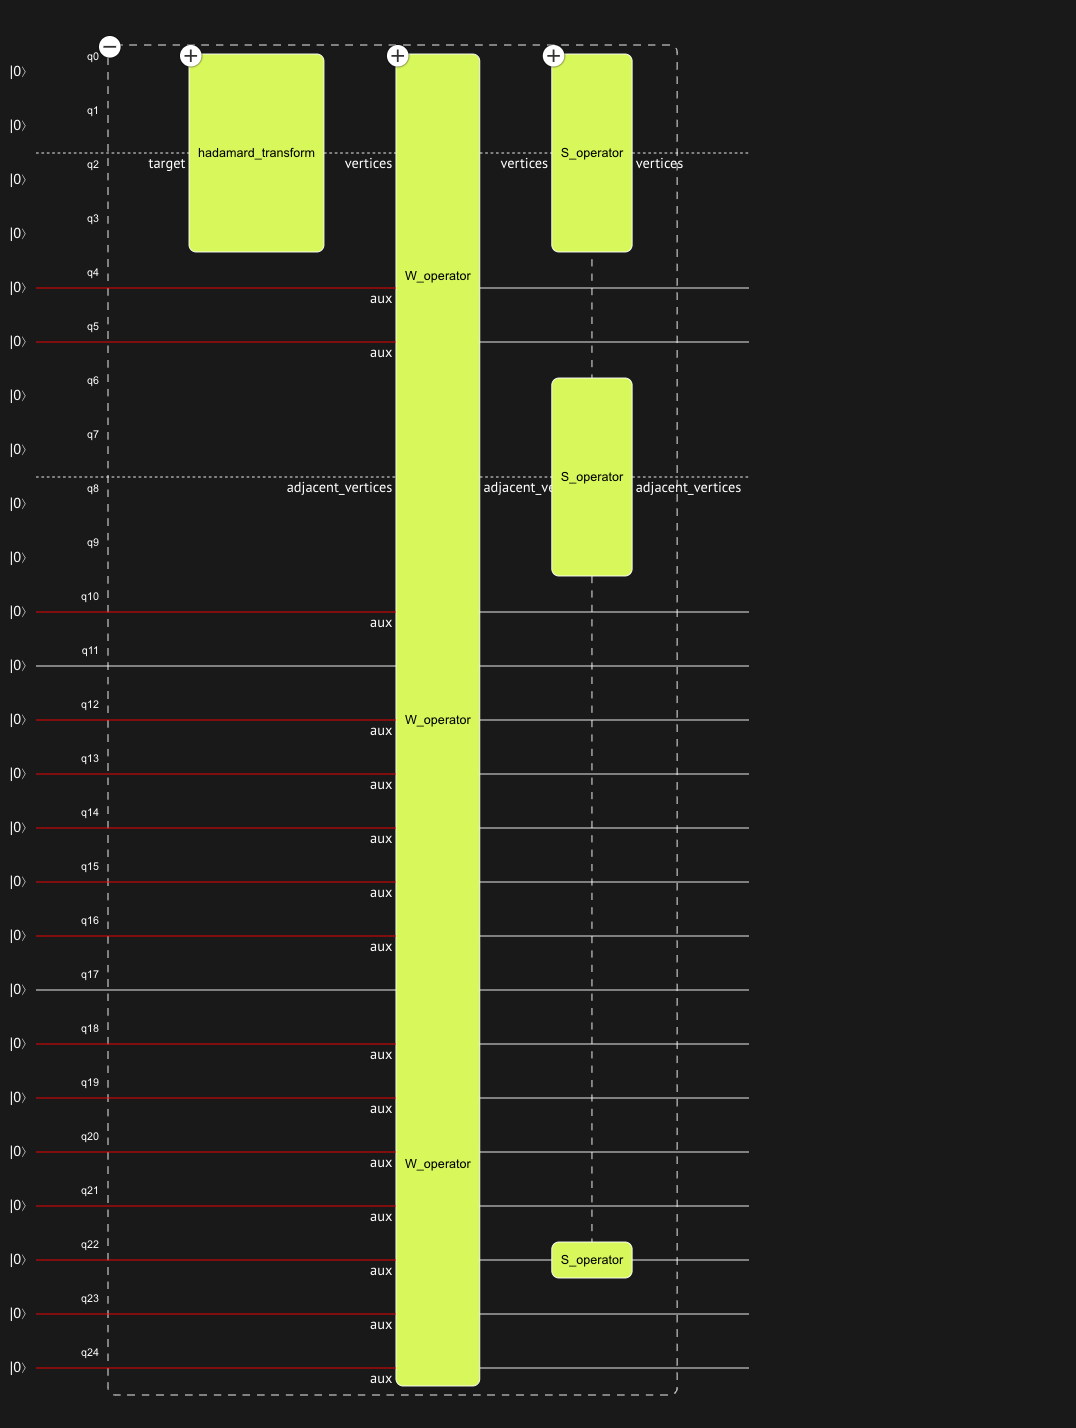

I ran the algorithm a few times. Sometimes I got a 26 width and sometimes 25.
I executed program with 25 width, and 5000 shots.
Here is the probability results after measurement

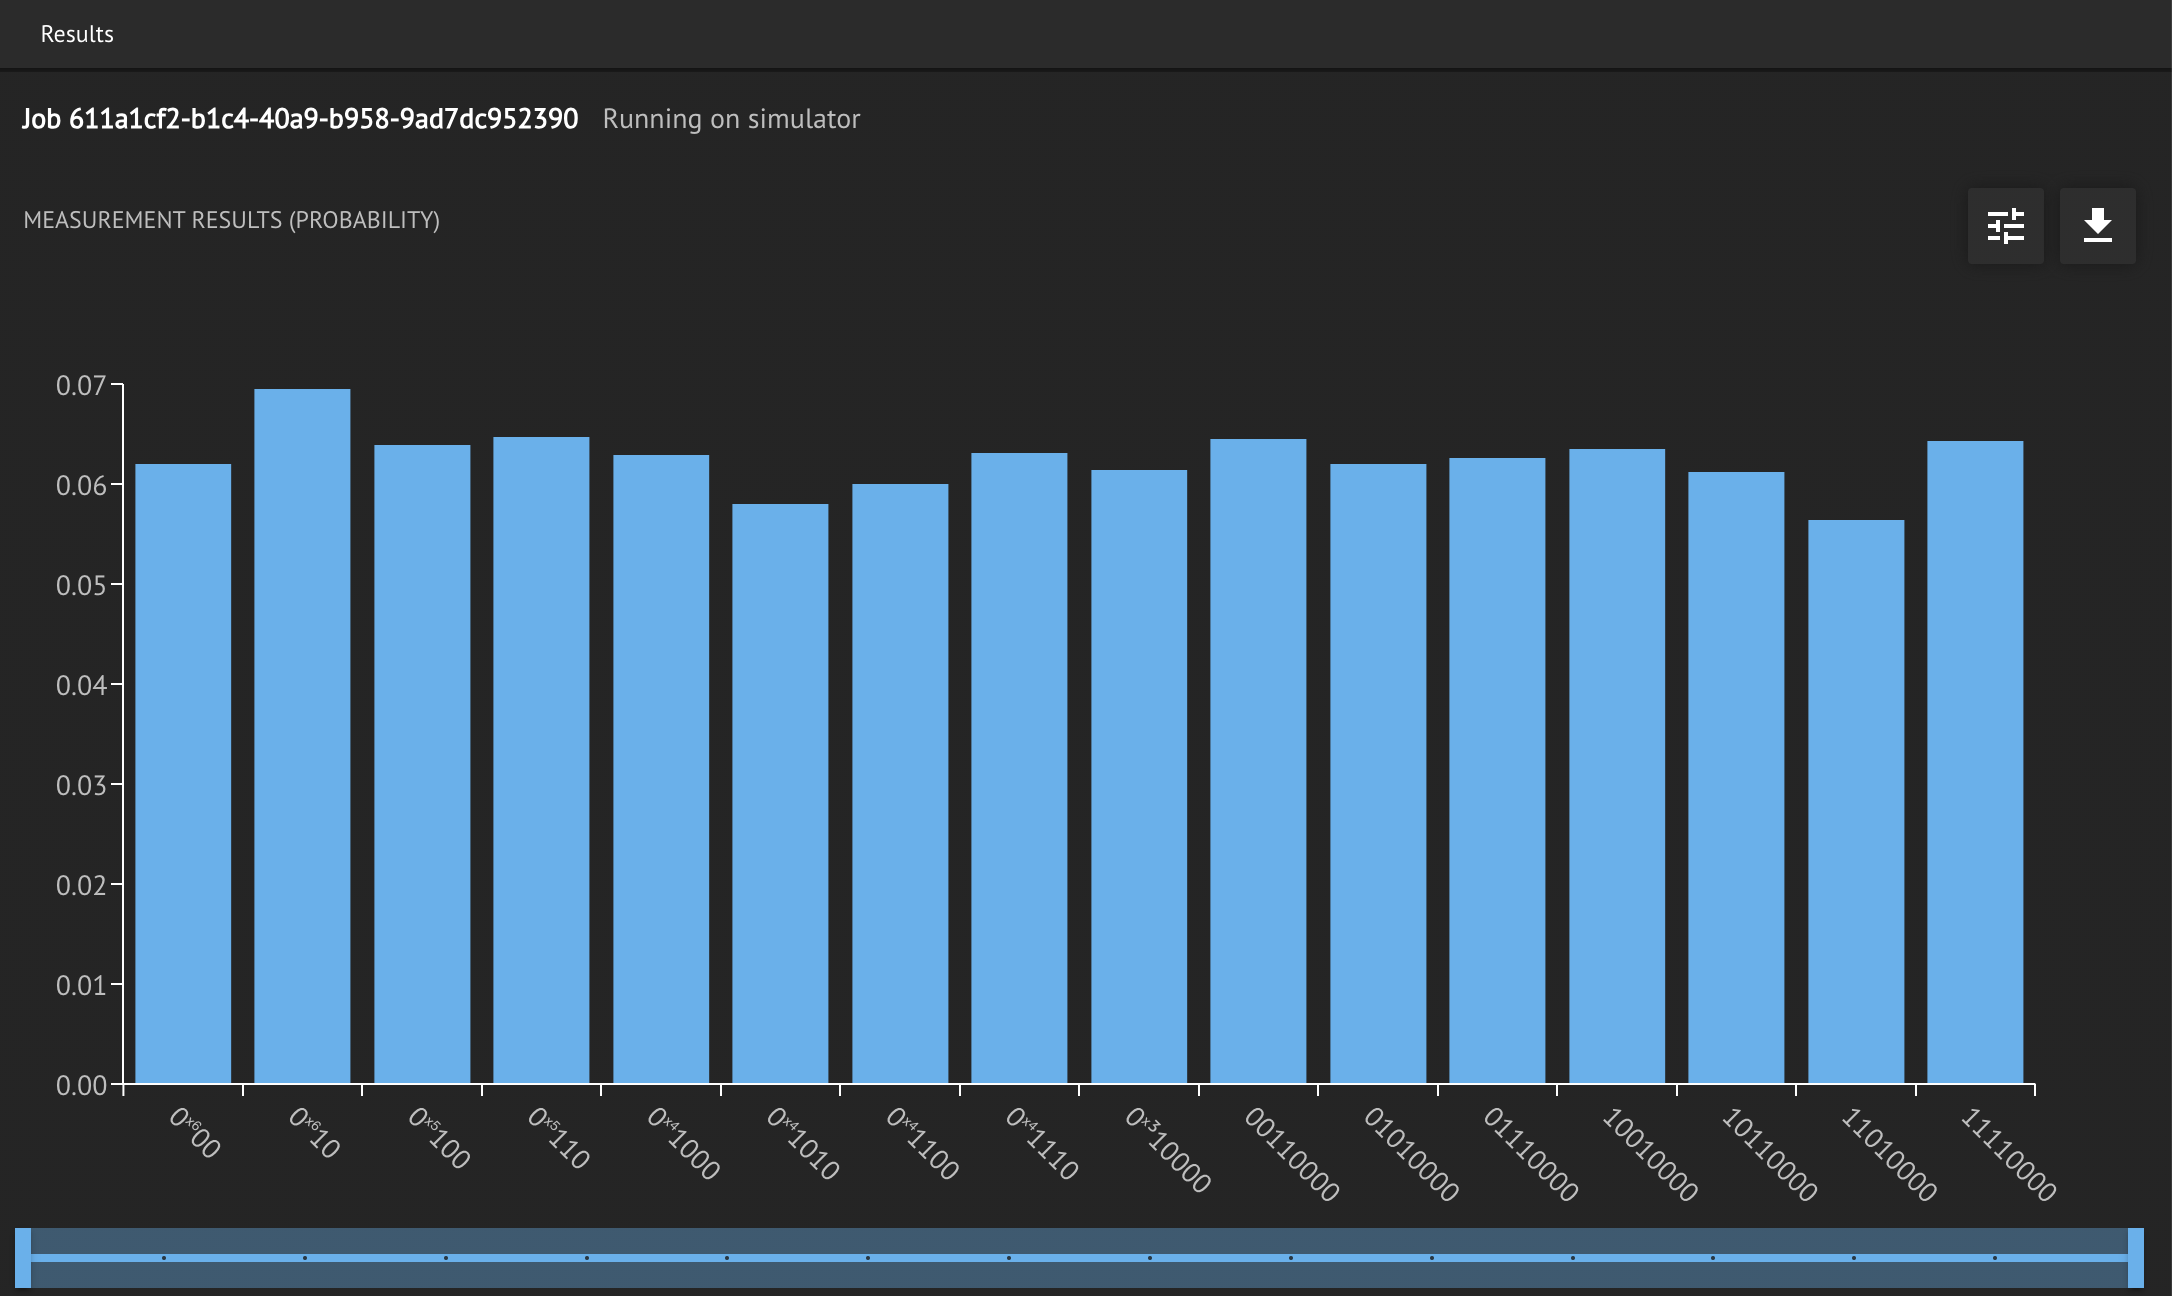

This is interesting!
The bars have approximately equal heights(probabilities)!

This means  that the quantum walk has led to a nearly uniform distribution of probabilities across all the states. So, after the walk, the walker has an almost equal probability of being found at any node on the line!

I ran the same program for 16000 shots just to see if we could gain more statistical confidence:

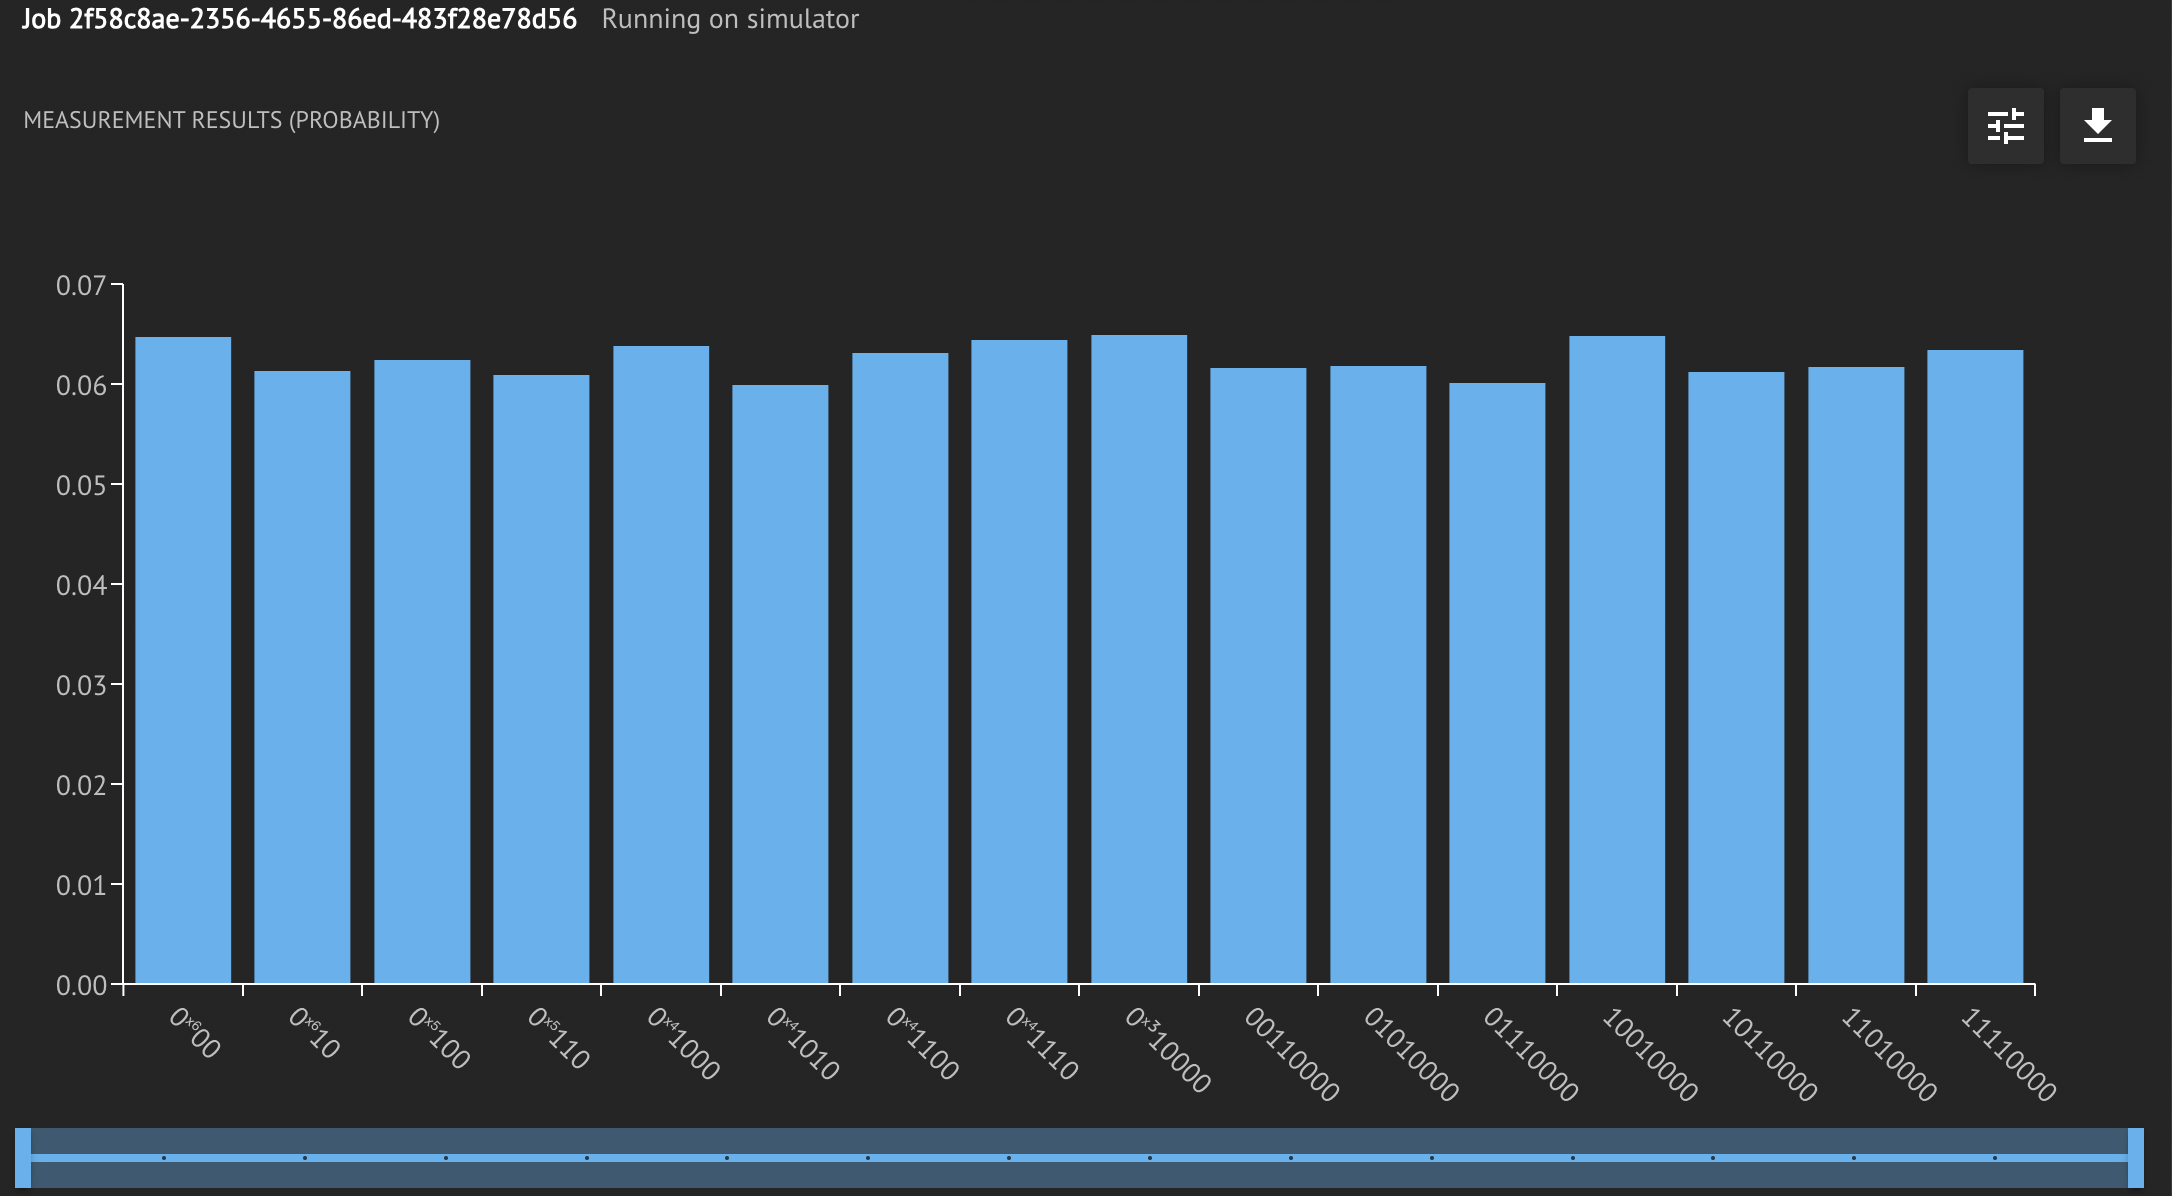

The result is indeed slightly more uniform!